## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

***Following is the list of Important Libraries required for the Project.

In [1]:
import matplotlib.image as mpimg #For reading the images.
import matplotlib.pyplot as plt #For plotting the images.
import numpy as np
import cv2 # For image related operations
import glob #Reading images of a type in a file
import time #To print time taken on each operations.
#from sklearn.svm import LinearSVC
from sklearn.svm import SVC #Classifier
from sklearn.preprocessing import StandardScaler #For Pre-processing operations
from skimage.feature import hog #Apply hog features
from moviepy.editor import VideoFileClip

### 1. Extraction of HOG and other Color Features of an image.
The following cell contains 3 methods,

**bin_spatial :

This fucntion returns the 'binned color features' taking the 'image' and 'size=(32,32)' into which the image is re-sized as input parameters.   
    
**color_hist :

This function retuns the 'color histogram features' with the help of 'image', 'bin_size=32' and 'bin_range=(0,256)' as inputs.
    
**get_hog_features:

This function returns the hog features and also the visualization of hog featured image if passed with vis=True as input parameter. Other imput parameters passed were, image, orient=9, pix_per_cell=8, cell_per_block=2,vis=False, feature_vec=True

In [2]:

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

**Following function - "extract_features" helps us to actually extract the required features from the dataset of images of Vehicles & Non-Vehicles. In this function, we read the images and normalize the pixel values in range(0,1) as there would be images of different formats while testing & training. The image is later converted to color_space = 'YCrCb'which worked well for me compared to rest color_spaces, Then we extract the color & HOG features of the image with the help of defined functions. The HOG channel used is 'ALL' rather than any of three as it provides clearer output.
The function returns the combined features for an image i.e. the combination of Color features - bin, histogram and HOG features respectively.

In [3]:
def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Following cell contains a code that distributes the dataset into 2 arrays that defines the 'Vehicle' and 'Non-Vehicle' images respectively.

In [4]:
car_images = glob.glob(r'./vehicles/*/*.png')
non_car_images = glob.glob(r'./non-vehicles/*/*.png')

cars = []
notcars = []
for image in car_images:
    cars.append(image)
for image in non_car_images:
    notcars.append(image)
print(len(cars))
print(len(notcars))

8792
8963


#### Following is an example of 'Vehicle' & 'Non-Vehicle' image and their corresponding HOG features respectively.

True

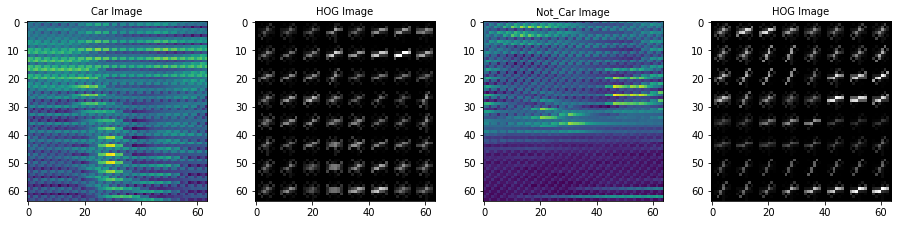

In [5]:
example_car=mpimg.imread(cars[5])
example_car=np.resize(example_car,(64,64))
#print(example_car.shape)
feat1,hog_car = get_hog_features(example_car, 9, 8, 2, vis=True, feature_vec=True)
example_not_car=mpimg.imread(notcars[5])
example_not_car=np.resize(example_not_car,(64,64))
feat2,hog_not_car = get_hog_features(example_not_car, 9, 8, 2, vis=True, feature_vec=True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 12))
f.tight_layout()
ax1.imshow(example_car)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(hog_car,cmap='gray')
ax2.set_title('HOG Image', fontsize=10)
ax3.imshow(example_not_car)
ax3.set_title('Not_Car Image', fontsize=10)
ax4.imshow(hog_not_car,cmap='gray')
ax4.set_title('HOG Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./output_images/Car.jpg',example_car)
cv2.imwrite('./output_images/HOG_Car.jpg',hog_car)
cv2.imwrite('./output_images/Not_Car.jpg',example_not_car)
cv2.imwrite('./output_images/HOG_Not_Car.jpg',hog_not_car)

Following cell Lists the Parameters with corresponding values which fits the best for my classifier and would be used to extract the features of images in a dataset.

In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,656] # Min and max in y to search in slide_window()
scale=1.5
#print(y_start_stop)
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(car_features))
print(len(notcar_features))

8792
8963


Following are the list of packages which are used to split the dataset randomly into Test and Train set, and define label vectors apprpriately.

In [7]:
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

In [8]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


The following block declares the Classifier that is being used, I have used SVM classifier with kernel : 'rbf' and values of C:1.0, gamma='auto' and degree:3 respectively.

In [9]:
# Use a linear SVC 
#svc = LinearSVC()
svc= SVC(C=1.0,kernel='rbf',degree=3,gamma='auto')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

251.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


### 2. Sliding Window Search

The following function 'slide_window' takes following imputs- image, x_start_stop: defines the horizontal boundaries , y_start_stop_l: defines a list of vertical boundaries where the window of size xy_window_l:(64,64) [default value given] is used to hover around the section defined and predict the possibility of each image inside a window to be a car or not. The number of pixels by which the windows should move is defined by the xy_overlap:(0.7,0.7) parameter where 0.7 indicates 70% of window size can be overlapped which moving in both x,y directions.

The co-ordinates of all the windows defined in the cross-section of x_start_stop & y_start_stop is stored in an array and returned from the function.

In [10]:
def slide_window(img, x_start_stop=[None, None], y_start_stop_l=[[None, None]], 
                    xy_window_l=((64, 64)), xy_overlap=(0.7, 0.7)):
    # If x and/or y start/stop positions not defined, set to image size
    window_list = []
    for xy_window,y_start_stop in zip(xy_window_l,y_start_stop_l):
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
    return window_list

The following function - 'search_windows' takes the image portion captured by each window whose co-ordinates are retuned by the slide window method and apply the feature extraction on it and predicts if the image in a window is a car feature or not. So for the window images which is predicted as car images, the co-ordinates of only those are returned by the function. The function take all the parameters required to extract the Color & HOG features respectively. 

In [11]:
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

The following function 'single_img_features' is used by the 'search_windows' function to extract the feature of every window image captured.

In [12]:
def single_img_features(img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

The Following function - 'draw_boxes' takes the image, list of co-ordiates, color of box and thickness of box as input and returns the image with boxes drawn having co-ordinates as mentioned in second parameter.

In [13]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### Following is an example of image with slide_window, search_window applied.

(720, 1280, 3)


True

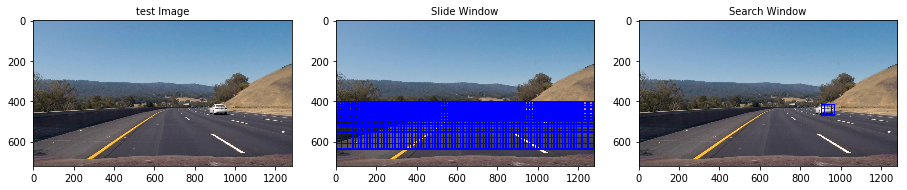

In [14]:
test_images = glob.glob(r'./test_images/*.jpg')
image=mpimg.imread(test_images[2])
draw_image = np.copy(image)
print(draw_image.shape)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
#image=cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
windows = slide_window(image, x_start_stop=[0, image.shape[1]], y_start_stop_l=((400,496),(400,656)), 
                  xy_window_l=((52,52),(96,96)), xy_overlap=(0.7, 0.7))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img1 = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)    
window_img2 = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('test Image', fontsize=10)
ax2.imshow(window_img1)
ax2.set_title('Slide Window', fontsize=10)
ax3.imshow(window_img2)
ax3.set_title('Search Window', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./output_images/test_image.jpg',image)
cv2.imwrite('./output_images/slide_window.jpg',window_img1)
cv2.imwrite('./output_images/search_window.jpg',window_img2)


The following block includes functions that help add heat feature to an image, apply threshold based on the heat feature and draw_labeled_boxes on it.

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#### Following are examples of image with heat appplied and marking the label box around it.

True

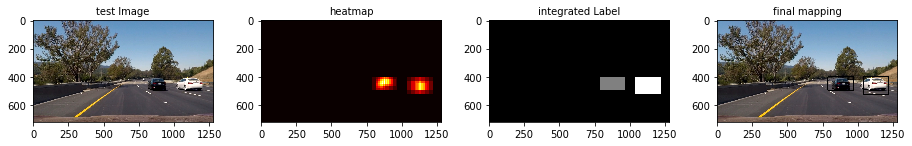

In [19]:
test_images = glob.glob(r'./test_images/*.jpg')
image=mpimg.imread(test_images[5])
image = image.astype(np.float32)/255
windows = slide_window(image, x_start_stop=[0, image.shape[1]], y_start_stop_l=((400,496),(400,656)), 
                  xy_window_l=((52,52),(96,96)), xy_overlap=(0.7, 0.7))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap=add_heat(heatmap, hot_windows)
heatmap = apply_threshold(heatmap,0)
labels = label(heatmap)
#print(labels[1], 'cars found')
#plt.imshow(labels[0], cmap='gray')
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(12, 12))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('test Image', fontsize=10)
ax2.imshow(heatmap,cmap='hot')
ax2.set_title('heatmap', fontsize=10)
ax3.imshow(labels[0],cmap='gray')
ax3.set_title('integrated Label', fontsize=10)
ax4.imshow(draw_img)
ax4.set_title('final mapping', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./output_images/test_image.jpg',image)
cv2.imwrite('./output_images/slide_window.jpg',window_img1)
cv2.imwrite('./output_images/search_window.jpg',window_img2)

In [20]:
draw_img= None
counter = 1

### Pipeline
The following block defines the pipeline for the project,
which takes the image as input, gets the windows possible in  the image with the help of slide_window function, then it searches for the window that contain the vehicle features and later applies threshold over the heatmap of searched windows and finally filters the windows that consist the required car feature.

In [21]:
from collections import deque
sumframe = deque(maxlen=20)
def pipeline(image):
    global counter
    global draw_img
    draw_image = np.copy(image)
    image1 = image.astype(np.float32)/255
    #image1=cv2.cvtColor(image1,cv2.COLOR_RGB2YCrCb)
    windows = slide_window(image1, x_start_stop=[600, image1.shape[1]], y_start_stop_l=((400,496),(400,656)), 
                       xy_window_l=((52,52),(96,96)), xy_overlap=(0.7, 0.7))

    hot_windows = search_windows(image1, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    heatmap = np.zeros_like(image1[:,:,0]).astype(np.float)
    heatmap=add_heat(heatmap, hot_windows)
    sumframe.append(heatmap)
    sum_heat = np.sum(sumframe,axis=0)
    heatmap = apply_threshold(sum_heat,20)
    labels = label(heatmap)
    #print(labels[1], 'cars found')
    #plt.imshow(labels[0], cmap='gray')
    draw_img = draw_labeled_bboxes(draw_image, labels)
    return draw_img


### Video-Implementaion 
The following cell is used to process the video sample, which is done by passing each frame of a video to the pipeline and extracting the required feature.

In [22]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(38,43)
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:30:49<00:07,  7.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2h 30min 51s


### Problems / issues  faced in my implementation of this project
The pipeline implemented works perfectly for most of the video section but finds some false positives in the shaded region which i feel can be improved with the help of sensors that might be helpful in detecting the range of nearby object or by using some other classifier or some added filters.